### Imports

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import itertools
import matplotlib.pyplot as plt
from terminaltables import AsciiTable

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

### Load datasets

In [2]:
# Load feature set and target values
dataset = pd.read_pickle("data/dataset")
# Load corresponding articles
articles = pd.read_pickle("data/articles")

### Prepare data

In [3]:
feature_names = [col for col in dataset.columns if col != "blog"]

# Turn into numpy arrays
X = normalize(dataset[feature_names].values)
y = dataset["blog"].values.flatten()

n = len(X)

# Test indices: 20% of total, randomly selected
test_idx = np.random.choice(range(n), size=int(0.2*n), replace=False)
train_idx = np.isin(np.arange(n), test_idx, invert=True)

# Split the training and test sets
X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]

### Classify

In [4]:
# Define classifier
clf = RandomForestClassifier(n_estimators=100)

# Fit - Train
clf.fit(X_train, y_train)

# Make a prediction on test set
y_pred = clf.predict(X_test)

# Measure the performance of the model
print ("Test set accuracy: %.2f%%\n" %  float(100*accuracy_score(y_test, y_pred)))

print (classification_report(y_test, y_pred, target_names=["News", "Blog"]))


Test set accuracy: 75.62%

             precision    recall  f1-score   support

       News       0.77      0.75      0.76      2041
       Blog       0.75      0.76      0.75      1959

avg / total       0.76      0.76      0.76      4000



### Save predictions

In [5]:
test_articles = articles.loc[test_idx]

# Save predictions
test_articles.loc[y_pred == 0, "prediction"] = "News"
test_articles.loc[y_pred == 1, "prediction"] = "Blog"

test_articles.to_csv("data/predictions.csv")

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


### Plot confusion matrix

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


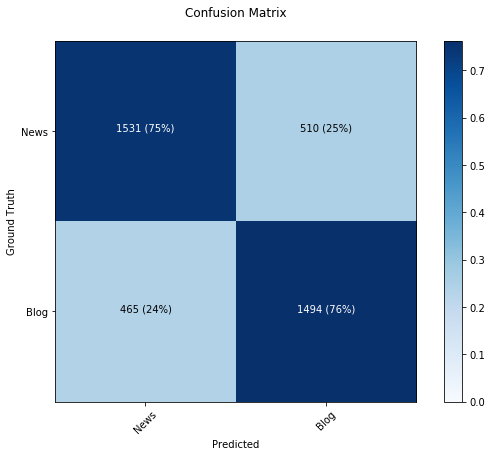

In [6]:

cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(8, 6))
plt.title("Confusion Matrix")
ax = fig.add_subplot(111)
cax = ax.matshow(cm_norm, interpolation='none', cmap=plt.cm.Blues, vmin=0, vmax=np.max(cm_norm))
ax.xaxis.tick_bottom()
fig.colorbar(cax)

thresh = cm_norm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, "%d (%.f%%)" % (cm[i,j], float(100*cm_norm[i,j])),
             horizontalalignment="center",
             color="white" if cm_norm[i, j] > thresh else "black")

plt.tight_layout()
    
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.xticks(np.arange(2), ('News', 'Blog'), rotation=45)
plt.yticks(np.arange(2), ('News', 'Blog'))

plt.show()
plt.close()

In [7]:
from keras.models import Sequential
from keras.layers import Activation, Dense


model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train,
          batch_size=64, epochs=5,
          validation_data=(X_test, y_test))

Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Train on 16000 samples, validate on 4000 samples
Epoch 1/5
16000/16000 [==============================] - 5s 336us/step - loss: 0.6937 - acc: 0.5027 - val_loss: 0.6930 - val_acc: 0.5105
Epoch 2/5
16000/16000 [==============================] - 4s 279us/step - loss: 0.6821 - acc: 0.5364 - val_loss: 0.6200 - val_acc: 0.6460
Epoch 3/5
16000/16000 [==============================] - 4s 277us/step - loss: 0.5925 - acc: 0.6879 - val_loss: 0.5732 - val_acc: 0.7188
Epoch 4/5
16000/16000 [==============================] - 4s 274us/step - loss: 0.5813 - acc: 0.7023 - val_loss: 0.5583 - val_acc: 0.7242
Epoch 5/5
16000/16000 [==============================] - 4s 247us/step - loss: 0.5809 - acc: 0.6982 - val_loss: 0.5577 - val_acc: 0.7232
